# Effect of replacing Child Tax Credit with Child Dividend

This identifies beneficiaries of the Child Tax Credit by modeling its repeal. Both repeal from current (2017) state and TCJA state are considered on a static basis. Change to after-tax income by decile and share of after-tax income held by top 10% are calculated.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.19.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 500
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Utilities

From https://stackoverflow.com/a/49571213/1840471.

In [6]:
def gini(x, w=None, zero_negatives=True):
    # Requires float numpy arrays (not pandas Series or lists) to work.
    x = np.array(x).astype('float')
    if zero_negatives:
        x[x < 0] = 0
    if w is not None:
        w = np.array(w).astype('float')
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumxw = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumxw) / cumxw[-1]) / n

2018 HHS Poverty Guidelines (Federal Poverty Level) for 48 Contiguous States and District of Columbia (Alaska and Hawaii have higher guidelines, but the data does not have state code): https://aspe.hhs.gov/poverty-guidelines

In [7]:
def fpl(XTOT):
    return 7820 + 4320 * XTOT

In [8]:
def weighted_sum(df, col):
    return (df[col] * df.s006).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

### Create reforms

CTC repeal involves eliminating the normal CTC as well as the new dependent credit for children.

A reform to return to 2017 CTC law is used to show how the distribution of CTC benefits changed with TCJA.

In [9]:
noctc_reform = {
    2018: {
        '_CTC_c': [0],
        '_DependentCredit_Child_c': [0]
    }
}

y2017_reform = {
    2018: {
        # Current: 1400.0
        "_CTC_c": [1000.0],
        # Current: [200000.0, 400000.0, 200000.0, 200000.0, 400000.0]
        "_CTC_ps": [[75000.0, 110000.0, 55000.0, 75000.0, 75000.0]],
        # Current: 2500.0
        "_ACTC_Income_thd": [3000.0],
        # Current: 600.0
        "_DependentCredit_Child_c": [0.0],
        # Current: True
        "_DependentCredit_before_CTC": [False]
    }
}

## Generate data

In [10]:
recs = tc.Records.cps_constructor()

In [11]:
def static_baseline_calc(year):
    calc = tc.Calculator(records=recs, policy=tc.Policy())
    calc.advance_to_year(year)
    calc.calc_all()
    return calc

In [12]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df.s006.cumsum() / df.s006.sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, 
                              df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_2percentile'] = np.ceil(df[col_pctile] / 2).astype(int)
    df[col + '_ventile'] = np.ceil(df[col_pctile] / 5).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [13]:
def static_calc(ctc_treatment='keep',
                year=2018,
                cols=['s006', 'aftertax_income', 'expanded_income',
                      'n24', 'XTOT'],
                child_tax_units_only=True):
    """Creates static Calculator.

    Args:
        ctc_treatment: How the Child Tax Credit is treated. Options include:
            * 'keep': No change. Default.
            * 'repeal': End entirely.
            * 'y2017': Use 2017 law.
        year: Year to advance calculations to.
        cols: Columns to extract per Calculator record. 
            Defaults to ['s006', 'expanded_income', 'aftertax_income', 'nu18',
            'n24', 'XTOT'].
        child_tax_units_only: Limit tax units to those with n24 > 0. 
            Quantiles are calculated after this filtering. Defaults to true.
        
    Returns:
        DataFrame with `cols` and percentile, decile, and quintile of 
        after-tax income.
    """
    pol = tc.Policy()
    # Enact reform based on ctc_treatment.
    # Repeal CTC unless it's kept.
    if ctc_treatment == 'y2017':
        pol.implement_reform(y2017_reform)
    elif ctc_treatment == 'repeal':
        pol.implement_reform(noctc_reform)
    # Calculate. This is needed to calculate the revenue-neutral UBI.
    calc = tc.Calculator(records=recs, policy=pol, verbose=False)
    calc.advance_to_year(year)
    calc.calc_all()
    # Create DataFrame and add identifiers.
    df = calc.dataframe(cols)
    if child_tax_units_only:
        df = df[df.n24 > 0]
    # Add percentiles.
    df = add_weighted_quantiles(df, 'expanded_income')
    df = add_weighted_quantiles(df, 'aftertax_income')
    # Add identifier.
    df['ctc_treatment'] = ctc_treatment
    # What's the column for the ID?
    df['id'] = df.index
    # Add weighted sums.
    df['s006_m'] = df.s006 / 1e6
    df['s006_b'] = df.s006 / 1e9
    df['expanded_income_b'] = df.expanded_income * df.s006_b
    df['aftertax_income_b'] = df.aftertax_income * df.s006_b
    df['n24_m'] = df.n24 * df.s006_m
    df['XTOT_m'] = df.XTOT * df.s006_m
    return df

In [14]:
scenarios = pd.concat([
    static_calc(ctc_treatment='keep'),
    static_calc(ctc_treatment='y2017'),
    static_calc(ctc_treatment='repeal')])

## Program cost and child allowance calculation

In [15]:
afti_summary = (
    scenarios.groupby('ctc_treatment')['aftertax_income_b', 'n24_m'].sum())
n24_m_total = afti_summary.iloc[0].n24_m
ctc_cost_b = (afti_summary.loc['keep'].aftertax_income_b -
              afti_summary.loc['repeal'].aftertax_income_b)
rev_neutral_ubi_per_n24 = 1000 * ctc_cost_b / n24_m_total
MAX_CTC = 2000
top_ubi_cost_b = n24_m_total * MAX_CTC / 1000 - ctc_cost_b
top_ubi_cost_b_pct = top_ubi_cost_b / ctc_cost_b

In [16]:
print('The CTC has an estimated total 2018 cost of ' + 
      '${:.1f}'.format(ctc_cost_b) + 'B.\n' +
      'This could fund a ${:,.0f}'.format(rev_neutral_ubi_per_n24) +
      ' child benefit for all {:,.0f}'.format(n24_m_total) +
      'M CTC-eligible children.\n' +
      'Topping up to $2,000 per CTC-eligible child would cost ' +
      '${:.1f}'.format(top_ubi_cost_b) + 
      'B, a {:.1f}'.format(top_ubi_cost_b_pct * 100) + '% increase.')

The CTC has an estimated total 2018 cost of $117.1B.
This could fund a $1,470 child benefit for all 80M CTC-eligible children.
Topping up to $2,000 per CTC-eligible child would cost $42.2B, a 36.0% increase.


Two comparison points:

1. PUF/TaxBrain estimates \$112.4B
2. [TPC's 2017 estimate](http://www.taxpolicycenter.org/publications/refundable-credits-earned-income-tax-credit-and-child-tax-credit/full) of \$52B plus [JCT's estimate](https://www.jct.gov/publications.html?func=startdown&id=5053) that TCJA's non-SSN reforms would cost \$68B starting in 2019, yields \$120B. The 2018 estimate of \$29B does not capture the refundable portions.

See https://github.com/open-source-economics/taxdata/issues/170.

Set revenue-neutral amount as a round number close to the quantified amount.

In [17]:
RN_UBI = 1450
rn_ubi_str = '${:,.0f}'.format(RN_UBI)

## Preprocess

### Widen data

Create `tu`, a `DataFrame` with one row per tax unit.

In [18]:
tu = scenarios.pivot_table(values='aftertax_income',
                           index='id', columns='ctc_treatment').reset_index()
tu.columns = ['id', 'afti_keep', 'afti_repeal', 'afti_y2017']

In [19]:
AFTI_QUANTILES = ['aftertax_income_percentile', 
                  'aftertax_income_2percentile', 'aftertax_income_ventile', 
                  'aftertax_income_decile', 'aftertax_income_quintile', 
                  'aftertax_income_quartile']

# Dimensions based on tax unit and baseline.
base_aftiq = (
    scenarios.loc[scenarios['ctc_treatment'] == 'keep',
                  np.append(['id', 'n24', 'n24_m', 's006', 'XTOT', 'XTOT_m'], 
                            AFTI_QUANTILES)])
# Same for repeal scenario for showing who gets CTC.
repeal_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'repeal',
                             np.append(['id'], AFTI_QUANTILES)]
repeal_aftiq.columns = np.append(['id'], 
                                 repeal_aftiq.columns[1:] + 
                                 '_repeal').tolist()

In [20]:
tu = pd.merge(pd.merge(tu, base_aftiq, on='id'), repeal_aftiq, on='id')

### Add UBI scenario after-tax incomes

In [21]:
tu['afti_ubi'] = tu.afti_repeal + tu.n24 * RN_UBI
tu['afti_tubi'] = tu.afti_repeal + tu.n24 * MAX_CTC

In [22]:
for i in ['keep', 'repeal', 'y2017', 'ubi', 'tubi']:
    tu['afti_' + i + '_b'] = tu['afti_' + i] * tu.s006 / 1e9

In [23]:
def add_ratios(df):
    df['repeal_afti_chg'] = df.afti_repeal_b - df.afti_keep_b
    df['repeal_afti_pctchg'] = 100 * df.repeal_afti_chg / df.afti_keep_b
    df['ubi_afti_chg'] = df.afti_ubi_b - df.afti_keep_b
    df['ubi_afti_pctchg'] = 100 * df.ubi_afti_chg / df.afti_keep_b
    df['tubi_afti_chg'] = df.afti_tubi_b - df.afti_keep_b
    df['tubi_afti_pctchg'] = 100 * df.tubi_afti_chg / df.afti_keep_b
    df['keep_afti_pp'] = 1000 * df.afti_keep_b / df.XTOT_m
    df['ctc_per_n24'] = 1000 * (df.afti_keep_b - df.afti_repeal_b) / df.n24_m
    df['ctc_per_n24_2017'] = (
        1000 * (df.afti_y2017_b - df.afti_repeal_b) / df.n24_m)
    df['ctc_per_n24_2018'] = df.ctc_per_n24 - df.ctc_per_n24_2017

In [24]:
add_ratios(tu)

Verify maximum CTC.

In [25]:
tu['ctc_per_n24'].max().round()

2000.0

In [26]:
tu['ctc_per_n24_2017'].max().round()

1000.0

### Quantile summaries

In [27]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [28]:
quart = quantile_summary(tu, 'aftertax_income_quartile')
quint = quantile_summary(tu, 'aftertax_income_quintile')
dec = quantile_summary(tu, 'aftertax_income_decile')
vent = quantile_summary(tu, 'aftertax_income_ventile')
twopct = quantile_summary(tu, 'aftertax_income_2percentile')
pct = quantile_summary(tu, 'aftertax_income_percentile')

In [29]:
vent['percentile'] = vent.index * 5 - 2.5
twopct['percentile'] = twopct.index * 2 - 1

## CTC analysis

### Households and children reached

In [30]:
tax_units_reached = tu.loc[tu['repeal_afti_chg'] < 0, 's006'].sum()
share_of_tax_units_reached = tax_units_reached / tu['s006'].sum()

In [31]:
print('The CTC will reach {:.1f}'.format(tax_units_reached / 1e6) + 
      'M tax units in 2018.\n' +
      'This is {:.1f}'.format(share_of_tax_units_reached * 100) + 
      '% of all tax units with CTC-eligible children.')

The CTC will reach 40.2M tax units in 2018.
This is 87.7% of all tax units with CTC-eligible children.


### CTC per child by percentile

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


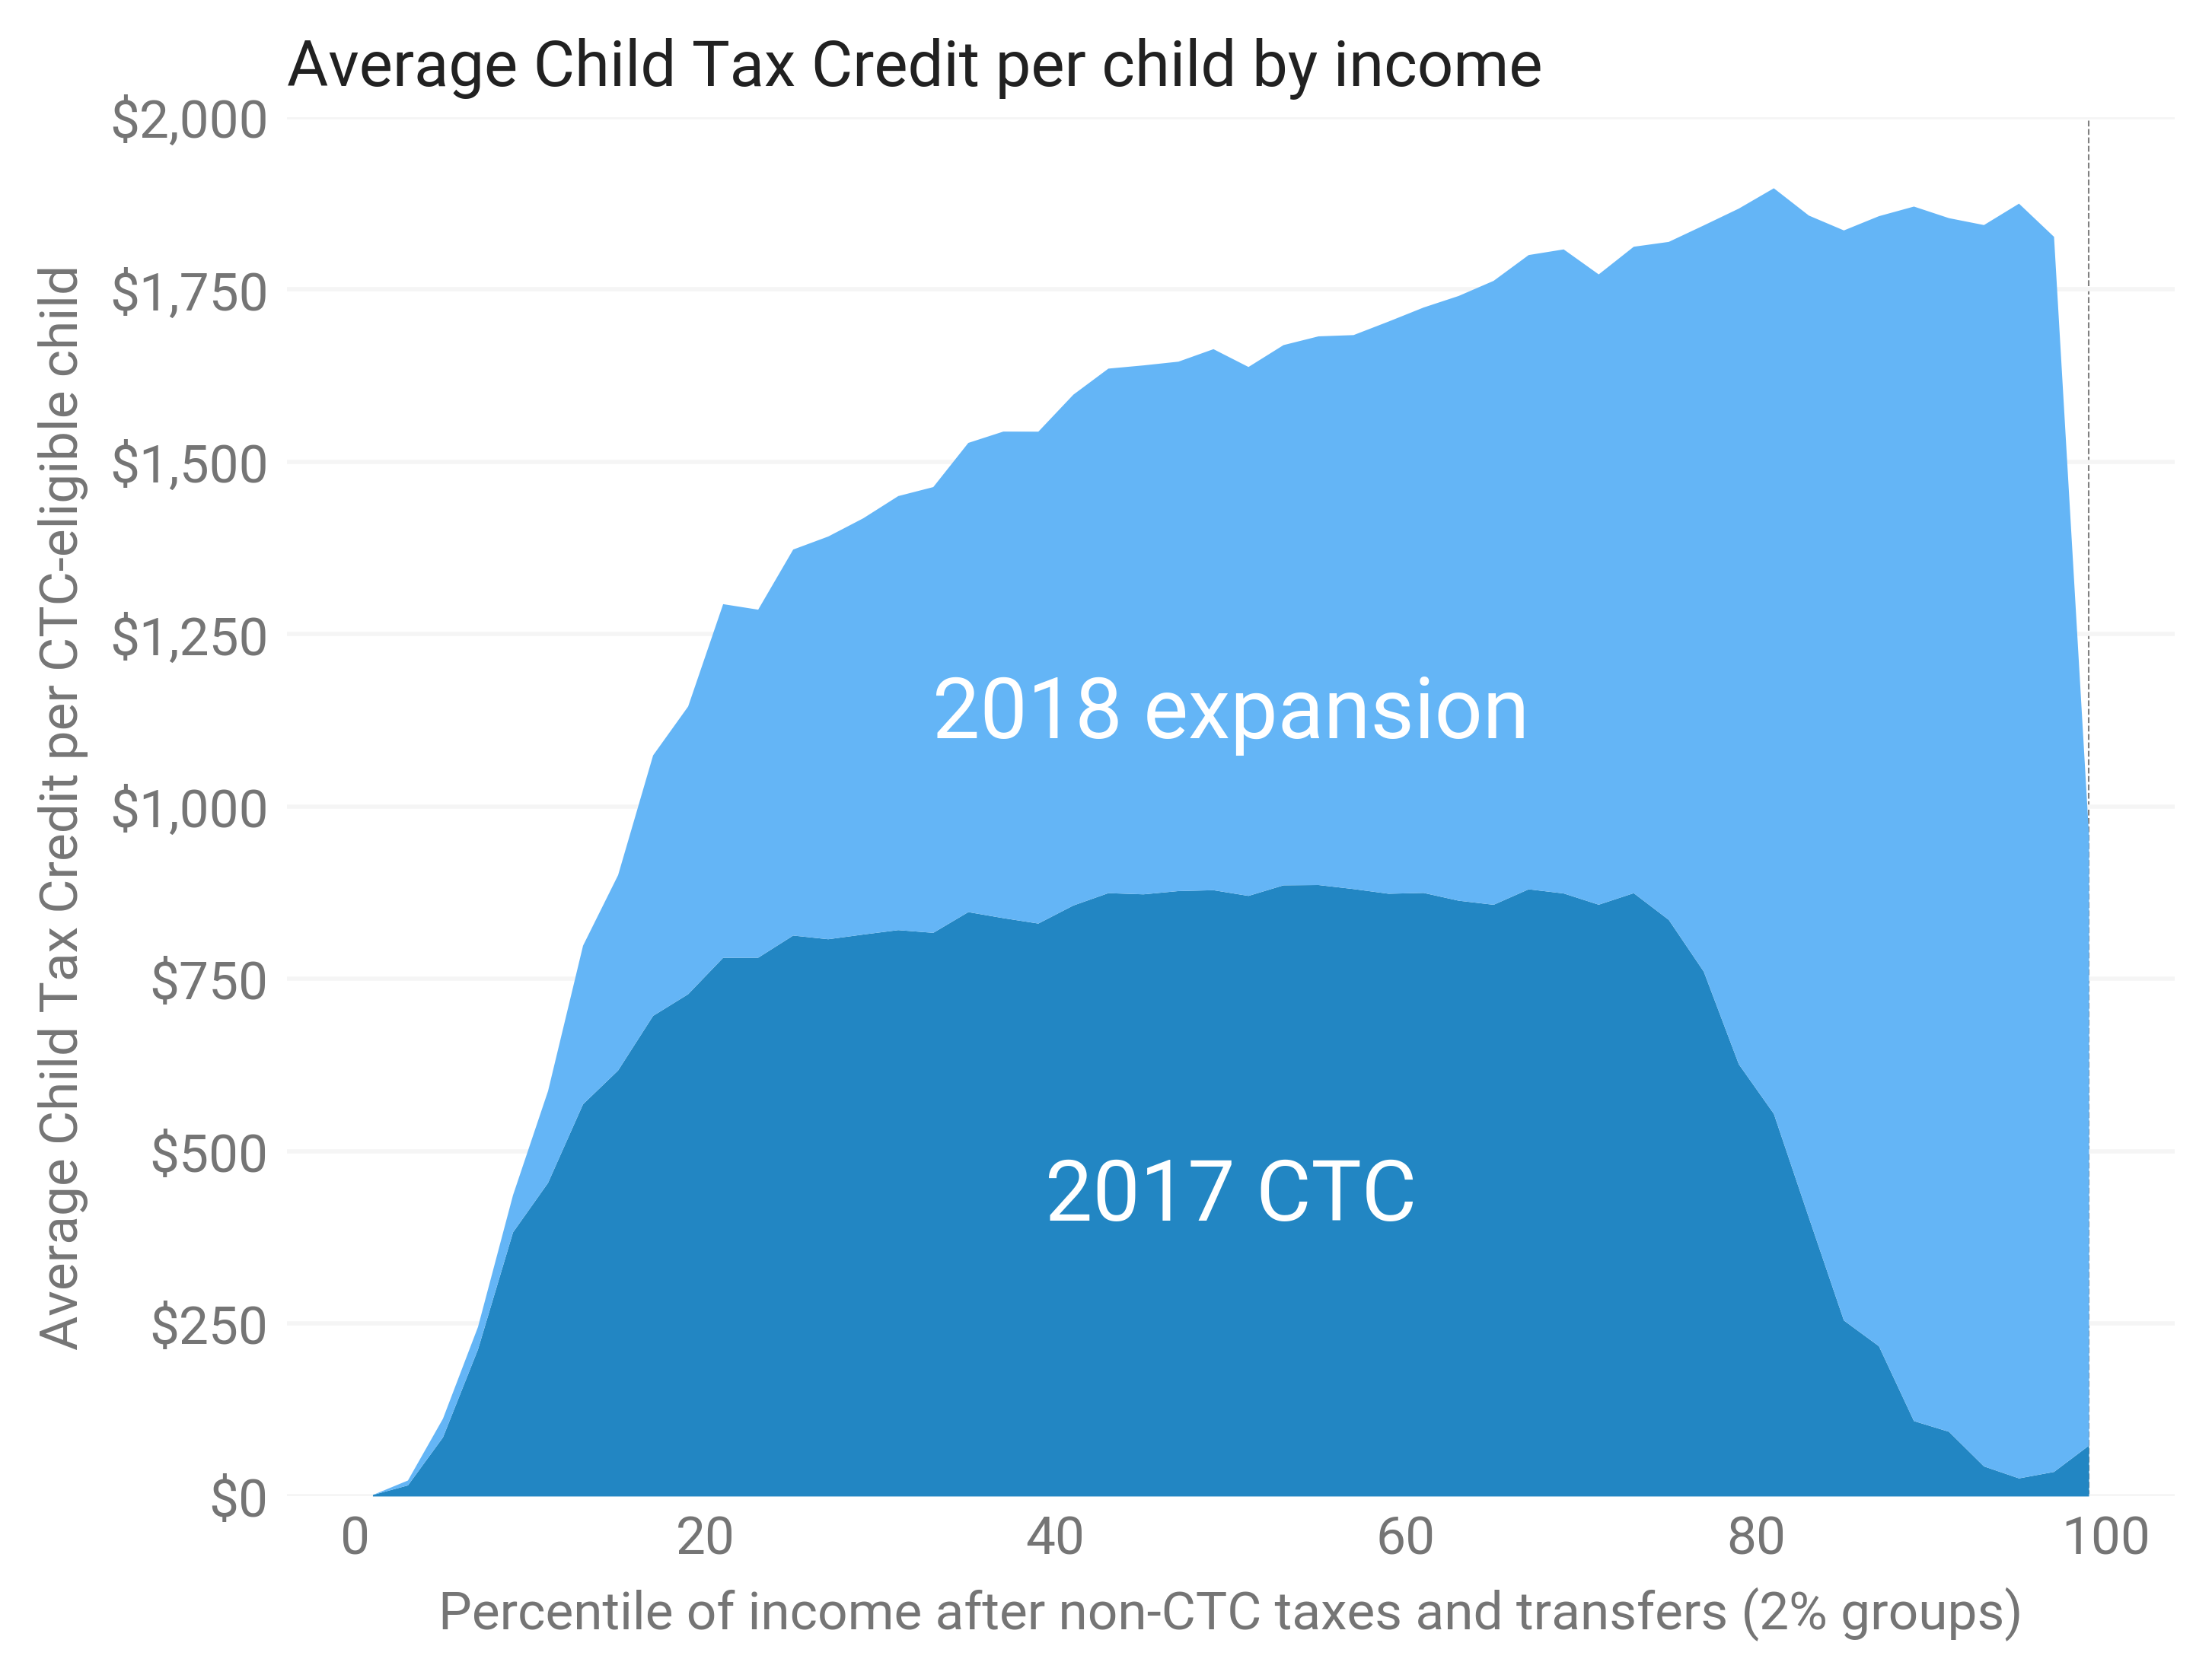

In [32]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
ax = twopct.plot(x='percentile', y=['ctc_per_n24_2017', 'ctc_per_n24_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0)
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after non-CTC taxes and transfers (2% groups)',
       ylabel='Average Child Tax Credit per CTC-eligible child',
       ylim=(0, 2000))
plt.axvline(x=99, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', 
        size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', 
        color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.title('Average Child Tax Credit per child by income', loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

## UBI vs. CTC

### Distributional impact

In [33]:
rn_ubi_str

'$1,450'

In [34]:
# One line.
UBI_LABEL = rn_ubi_str + ' (revenue-neutral)'
TUBI_LABEL = '$2,000 (current maximum)'
# Two lines.
UBI_LABEL2 = rn_ubi_str + '\n(revenue-neutral)'
TUBI_LABEL2 = '\$2,000\n(current maximum)'
# Three lines.
UBI_LABEL3 = '\\' + rn_ubi_str + '\n(revenue-\nneutral)',
TUBI_LABEL3 = '\$2,000\n(current\nmaximum)'

UBI_COLOR = '#757575'
TUBI_COLOR = '#388e3c'

UBI_LABELS = [UBI_LABEL, TUBI_LABEL]
UBI_COLORS = [UBI_COLOR, TUBI_COLOR]
UBI_COLS = ['ubi_afti_pctchg', 'tubi_afti_pctchg']

YLAB = 'Change to income after taxes and transfers'

#### Impact by quartile

In [35]:
quart[UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_quartile,,
1,6.73,11.50
2,-0.38,1.83
3,-0.72,0.67
4,-0.36,0.23


Overall impact on upper 75%.

In [36]:
upper_75p = quart.loc[2:].sum()
add_ratios(upper_75p)
with pd.option_context('precision', 2):
    print(upper_75p[UBI_COLS])

ubi_afti_pctchg    -0.46
tubi_afti_pctchg    0.58
dtype: float64


/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


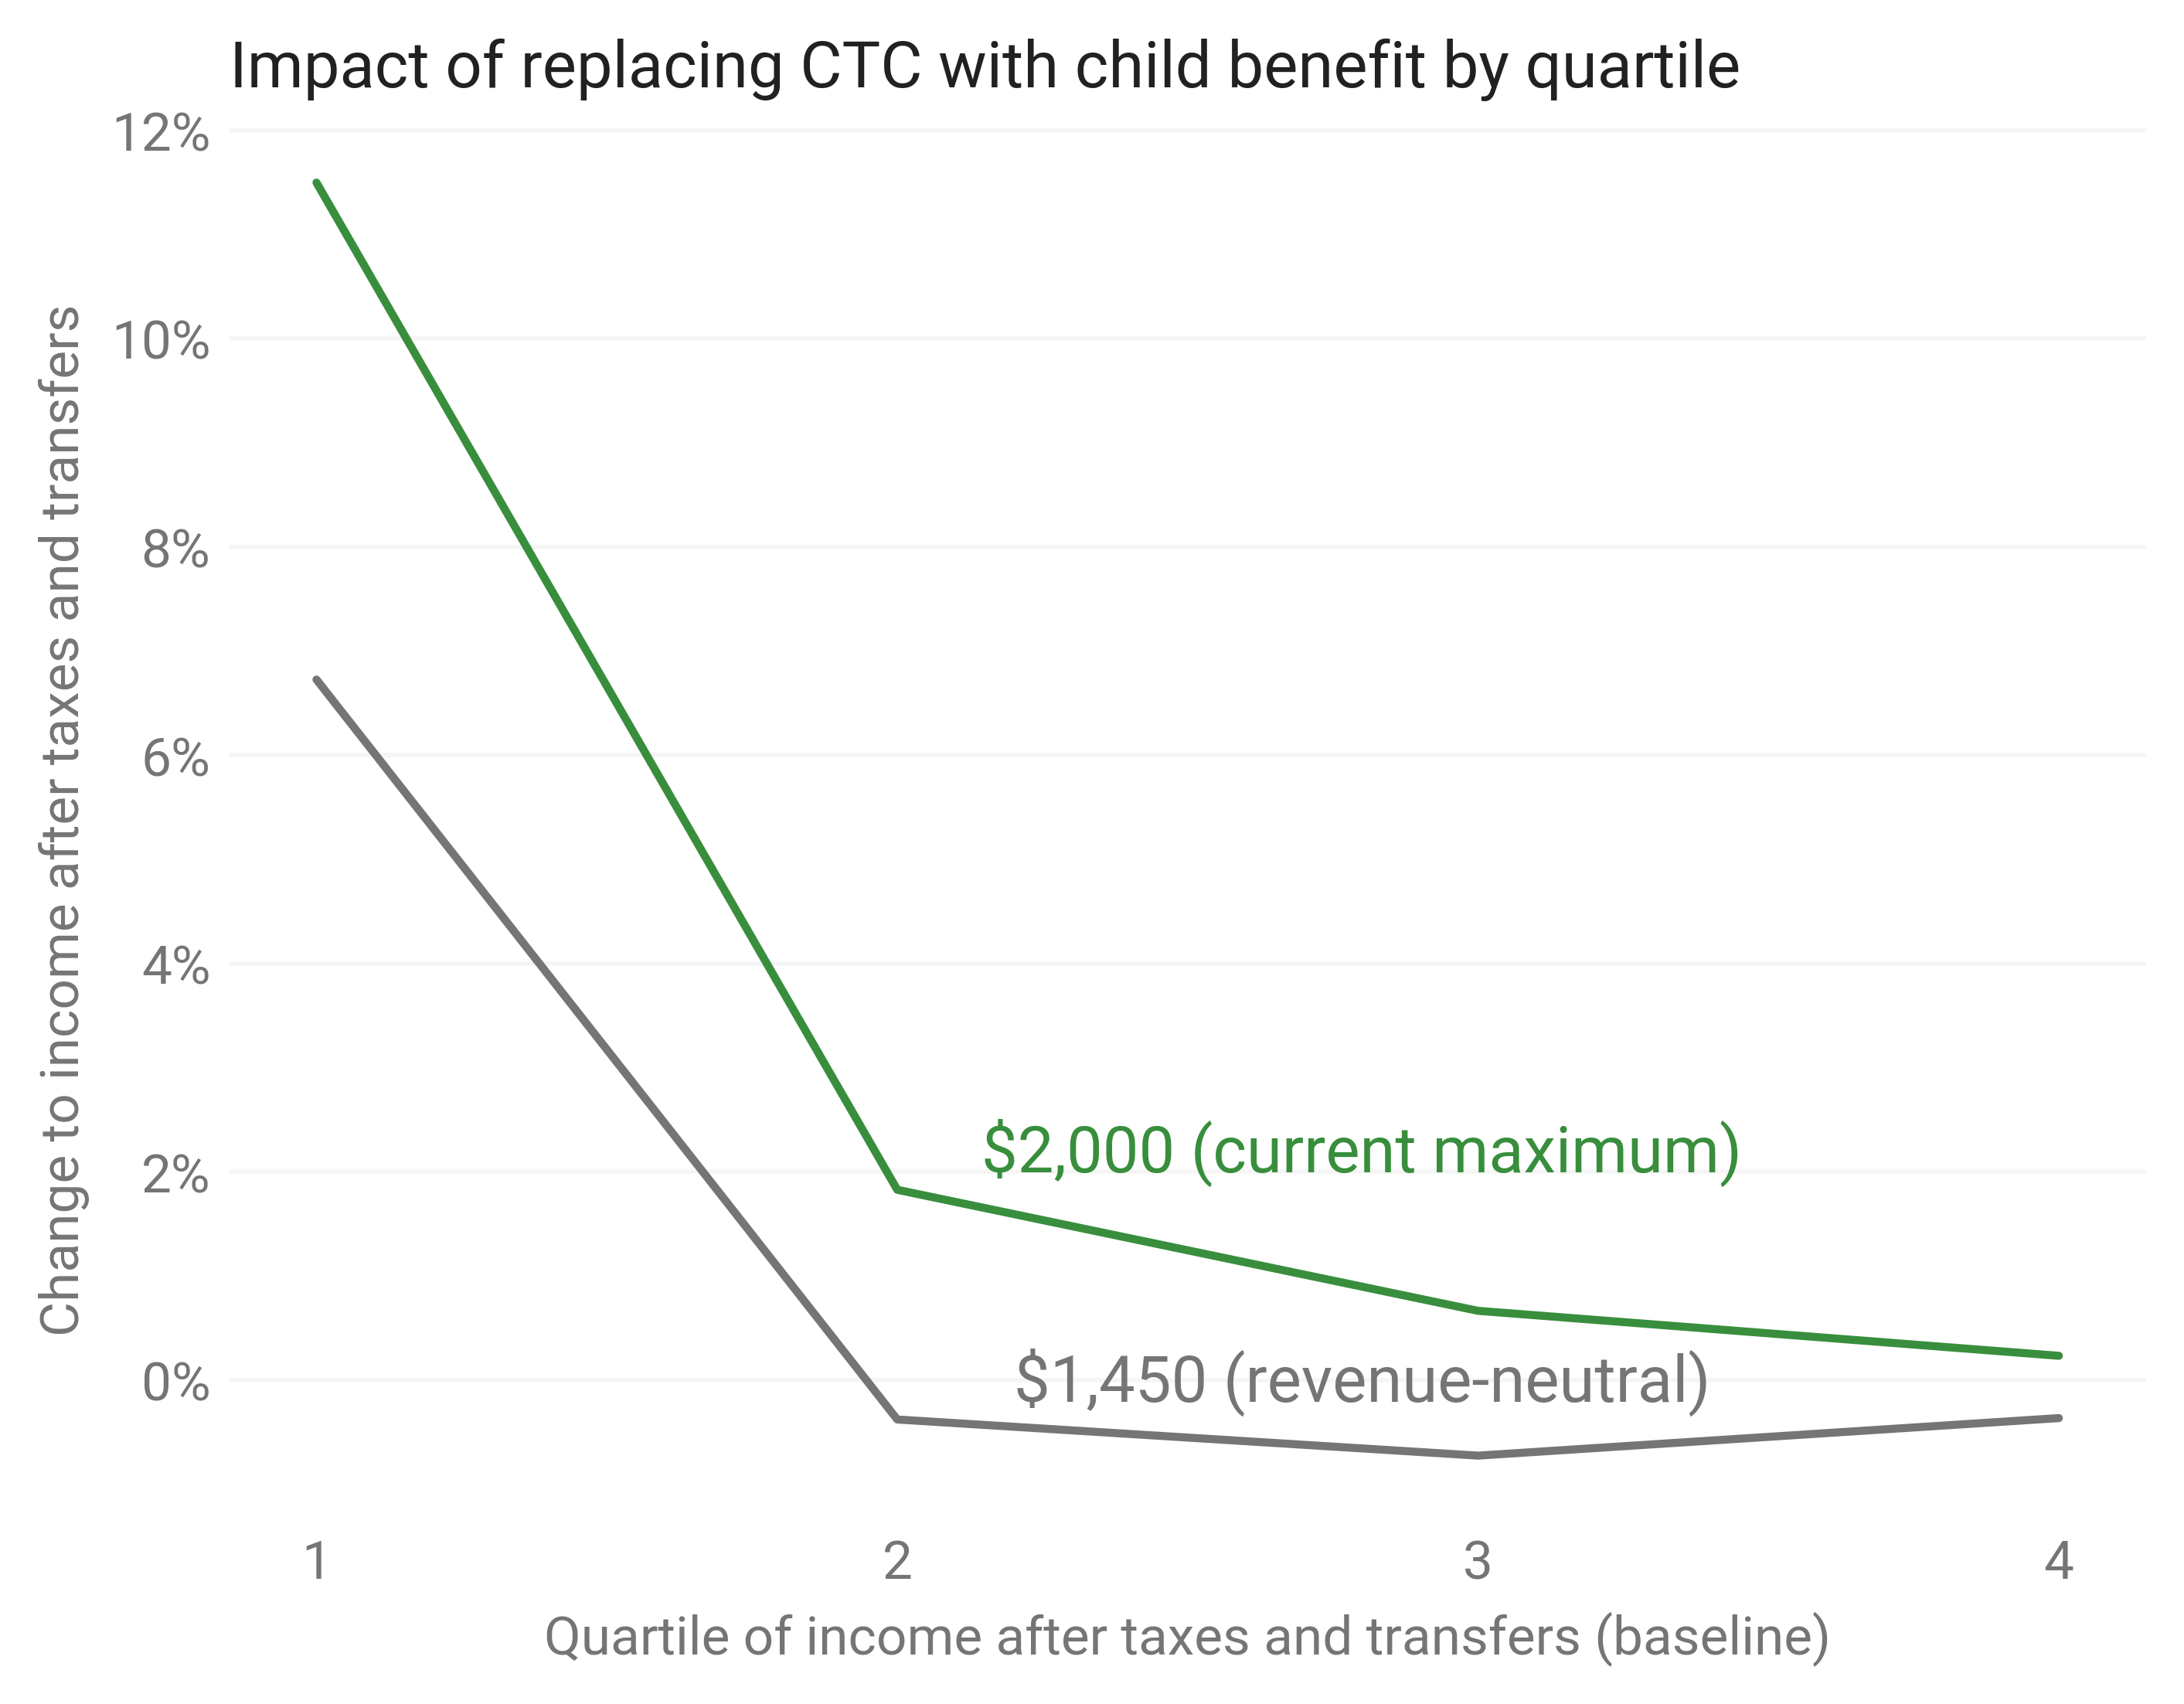

In [37]:
ax = quart.plot(y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(2.8, 2, TUBI_LABEL, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(2.8, -0.2, UBI_LABEL, horizontalalignment='center', 
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Quartile of income after taxes and transfers (baseline)',
       ylabel=YLAB,
       xticks=[1, 2, 3, 4])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Impact of replacing CTC with child benefit by quartile', 
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

#### Bottom quartile

In 5% increments.

In [38]:
vent.loc[:5, ['ubi_afti_pctchg', 'tubi_afti_pctchg', 'keep_afti_pp', 's006']]

,ubi_afti_pctchg,tubi_afti_pctchg,keep_afti_pp,s006
aftertax_income_ventile,,,,
1,116.71,161.76,1217.63,2.28e+06
2,16.70,24.71,6484.21,2.29e+06
3,5.53,9.72,9779.67,2.29e+06
4,2.11,5.24,11848.72,2.29e+06
5,0.78,3.58,12617.82,2.29e+06


\$1,065 per person per year is roughly $2.92 per day. 2.4M households in each ventile.

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


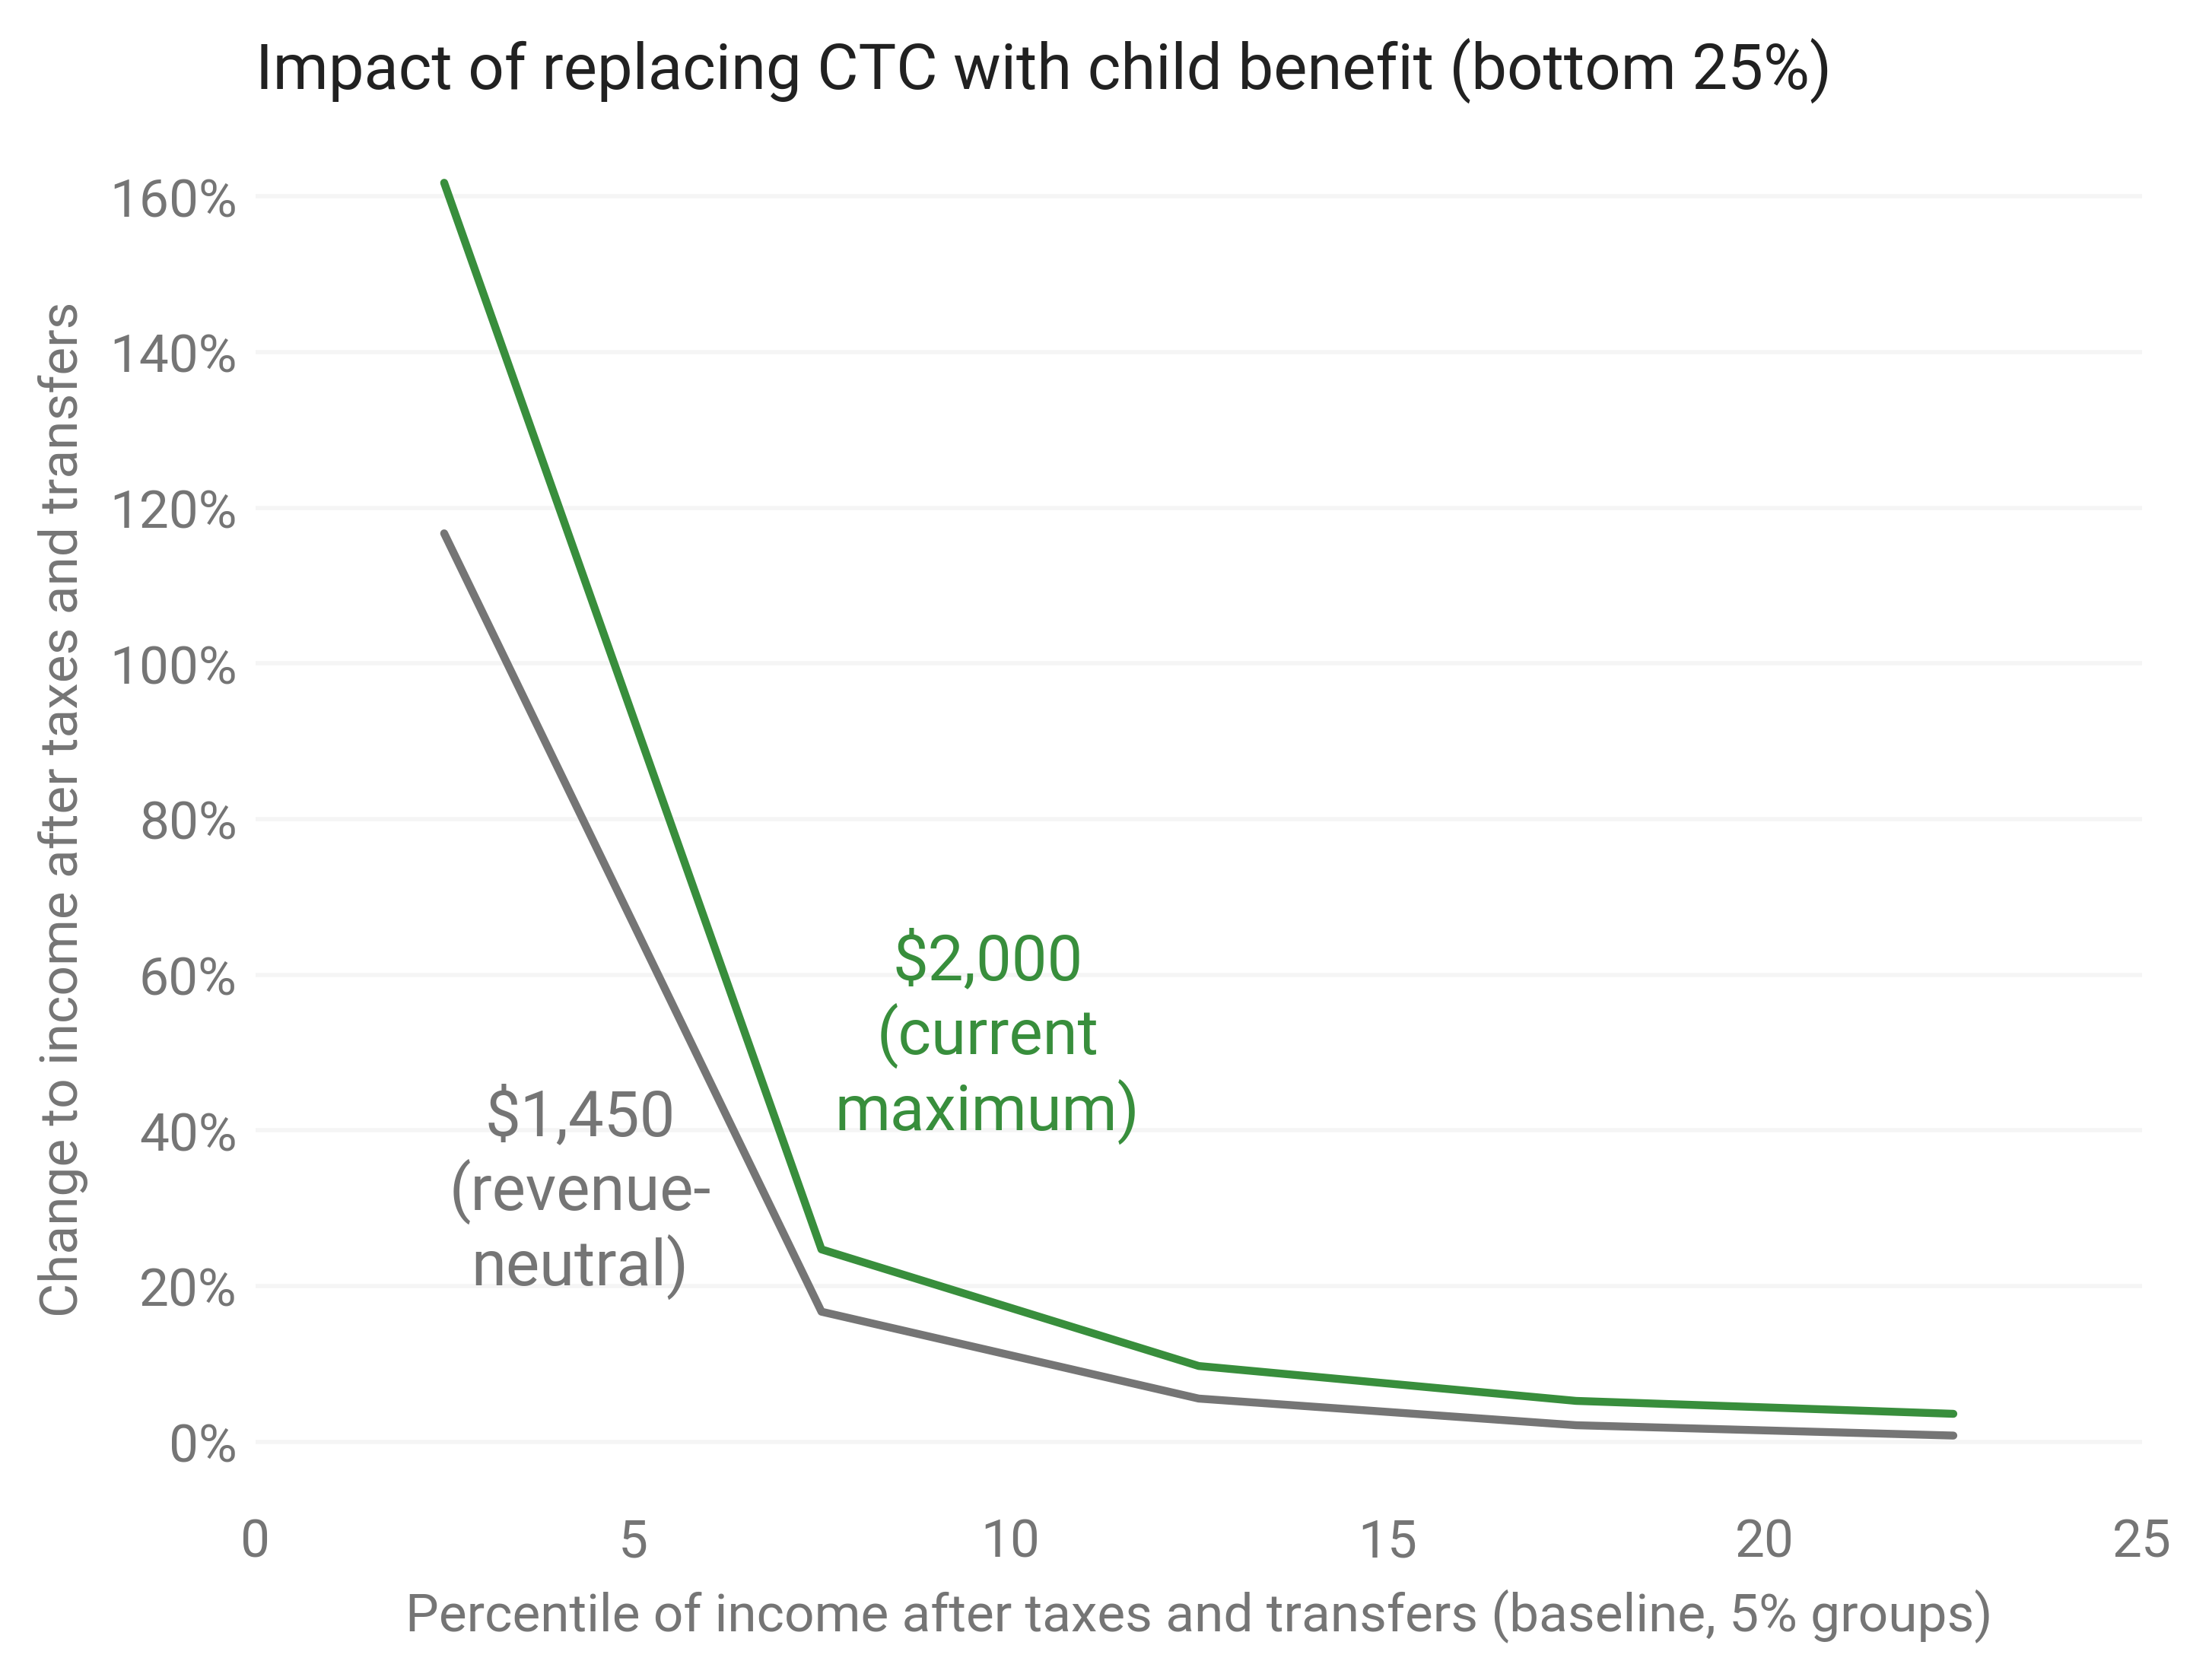

In [39]:
ax = vent[:5].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
# Using UBI_LABEL3 and TUBI_LABEL3 does not work.
ax.text(9.7, 40, '\$2,000\n(current\nmaximum)', horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(4.3, 20, rn_ubi_str + '\n(revenue-\nneutral)', 
        horizontalalignment='center',
        multialignment='center', color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 5% groups)',
       ylabel=YLAB,
       xlim=[0, 25])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (bottom 25%)', 
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

#### Impact on upper 75%.

In [40]:
twopct.loc[48:, UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_2percentile,,
48,-0.41,0.12
49,-0.30,0.14
50,0.19,0.41


/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


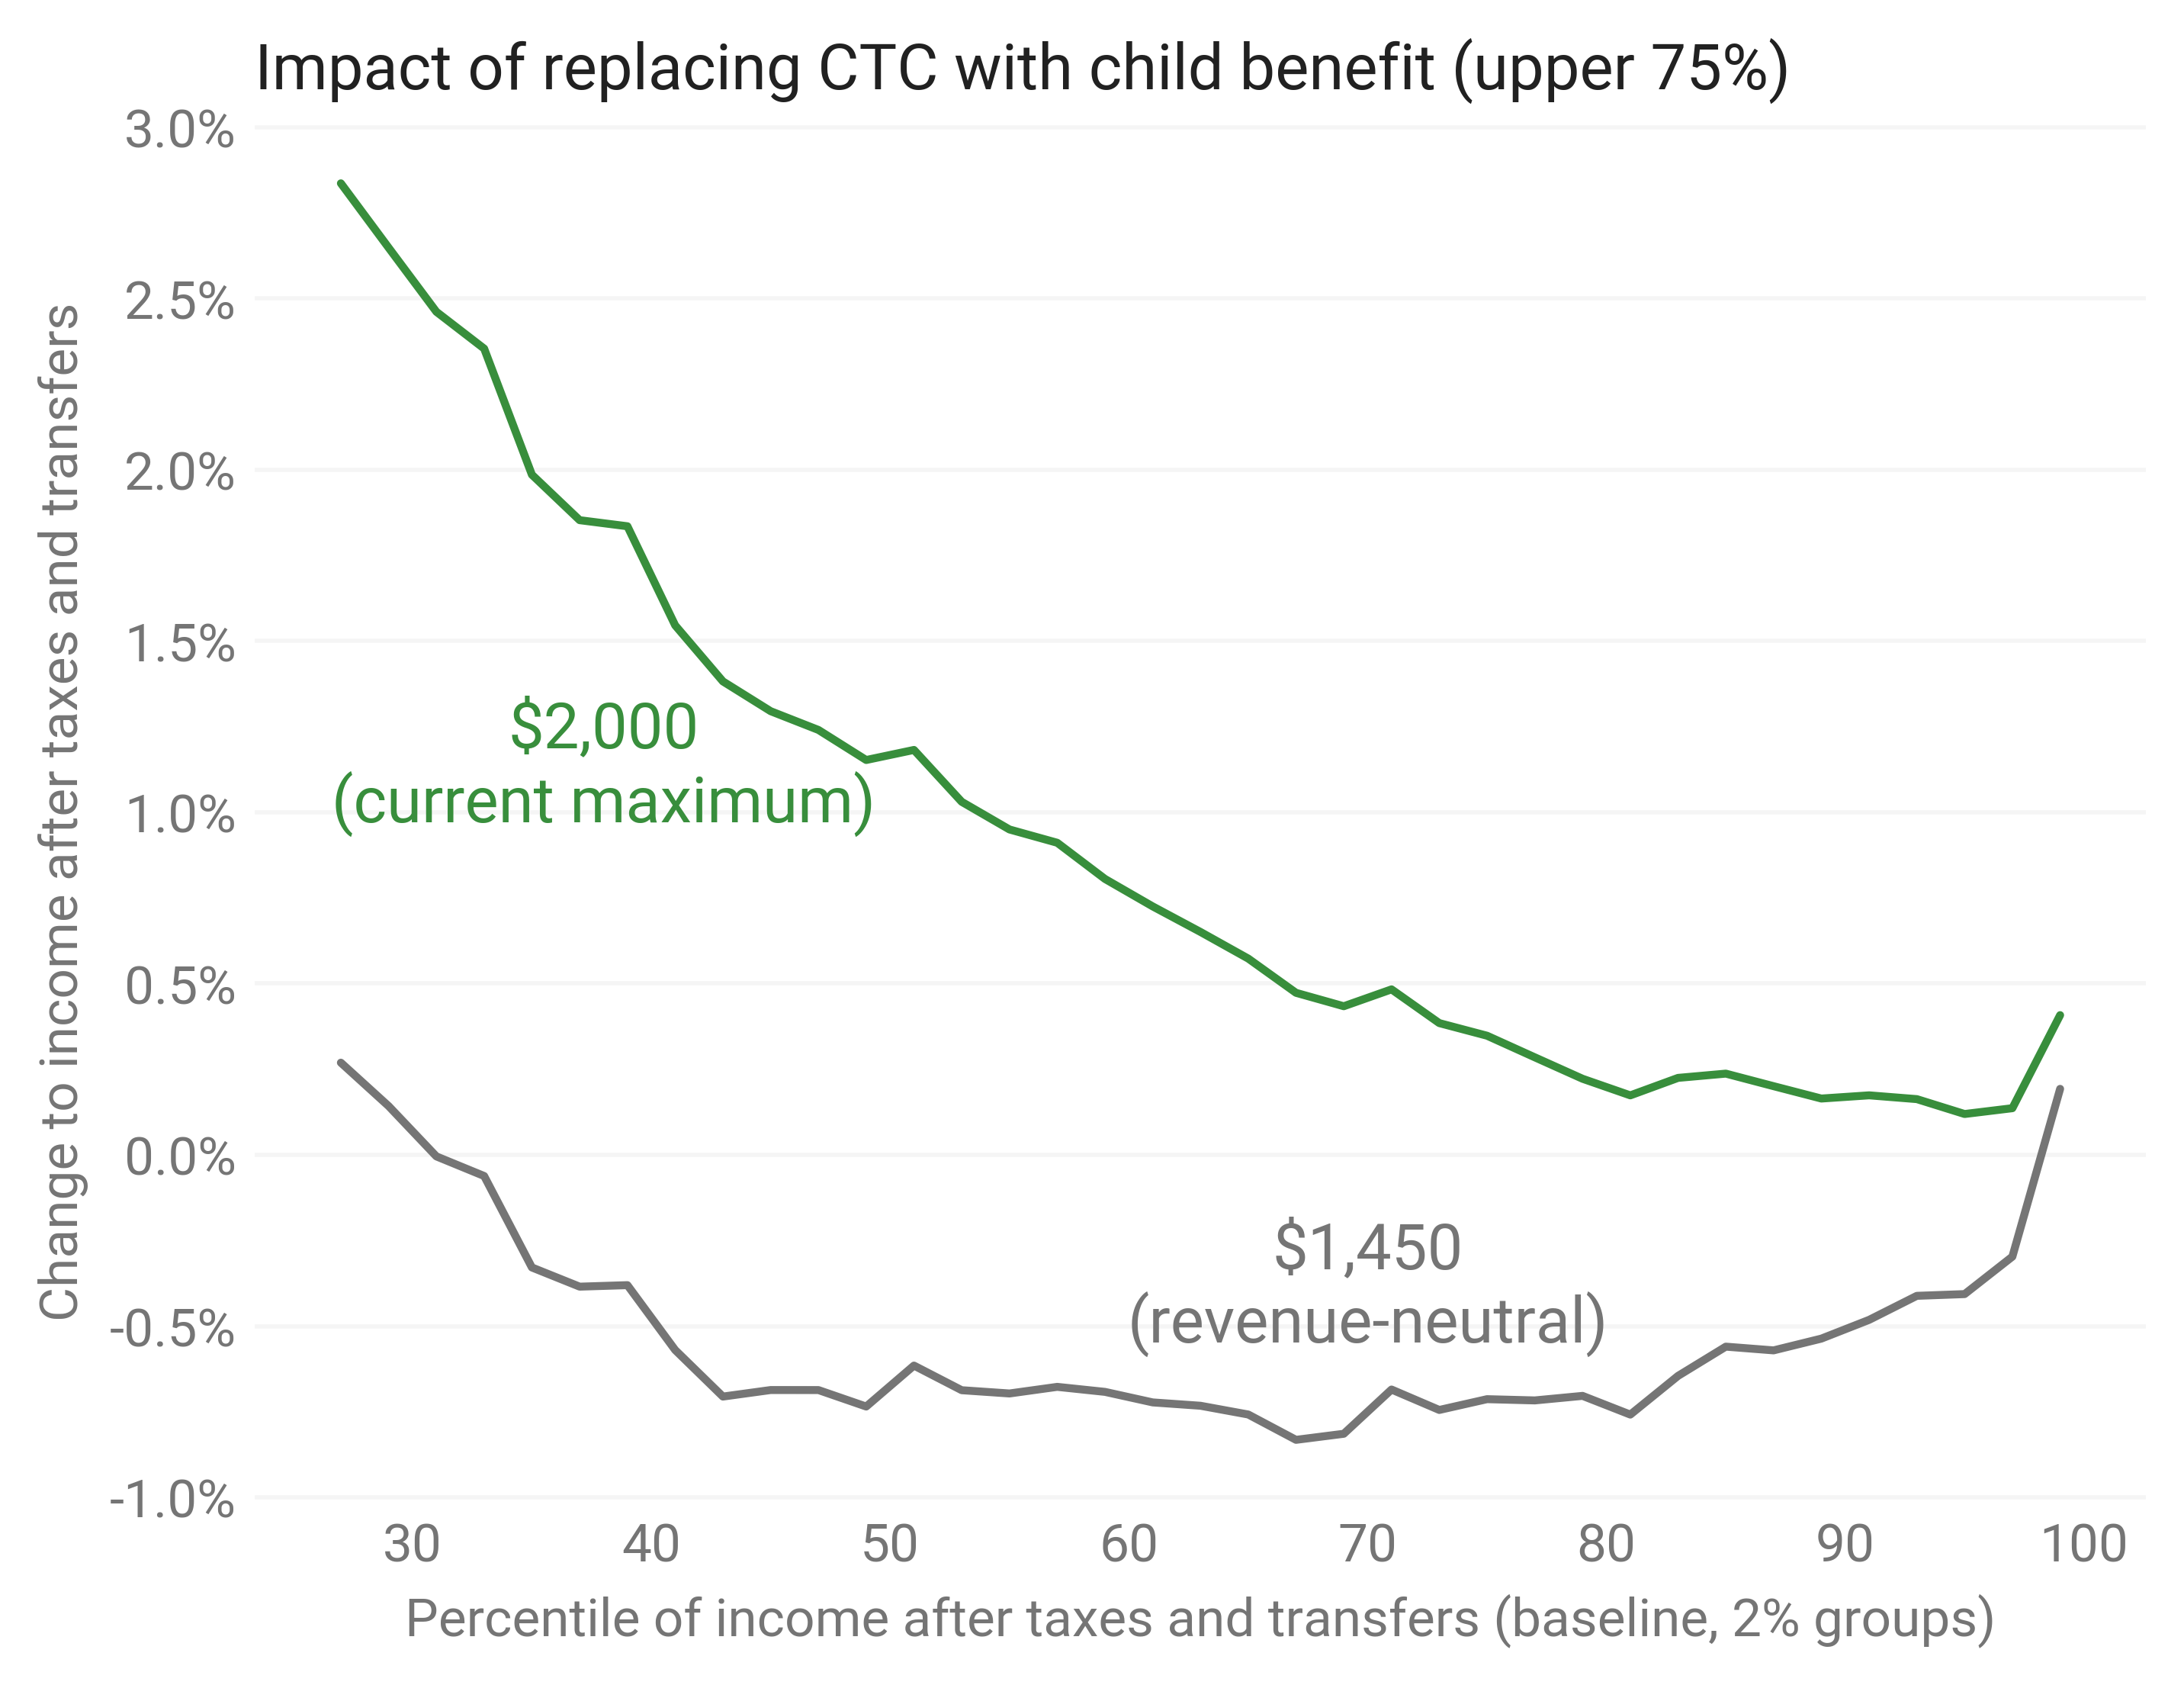

In [41]:
ax = twopct[13:].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
# ax.legend(UBI_LABELS)  # If new data.
ax.legend_.remove()
ax.text(38, 0.97, TUBI_LABEL2, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(70, -0.55, UBI_LABEL2, horizontalalignment='center',
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 2% groups)',
       ylabel=YLAB)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.1%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (upper 75%)',
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

Top 1% does better off. 2nd percentile is basically flat.

In [42]:
pct.loc[98:, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_percentile,,
98,-0.26,0.14
99,-0.11,0.22
100,0.34,0.50


In [43]:
twopct.loc[50, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

ubi_afti_pctchg     0.19
tubi_afti_pctchg    0.41
Name: 50, dtype: float64

### Inequality

#### Gini

In [44]:
ginis = pd.DataFrame({
    'keep': [gini(tu.afti_keep, tu.s006)],
    'repeal': [gini(tu.afti_repeal, tu.s006)],
    'ubi': [gini(tu.afti_ubi, tu.s006)],
    'tubi': [gini(tu.afti_tubi, tu.s006)]})

In [45]:
with pd.option_context('precision', 4):
    print(ginis)

     keep  repeal    tubi     ubi
0  0.4511  0.4602  0.4414  0.4464


### Poverty

In [46]:
tu['fpl'] = fpl(tu.XTOT)
tu['fpl_pp'] = tu.fpl / tu.XTOT
# Using $10k per person.
tu['pov_10k'] = 10000 * tu.XTOT
# $1.90 per day in 2011 dollars = $2.10 in 2018 dollars = $780/year.
EXTREME_POVERTY_LINE = 780
tu['extreme_pov'] = EXTREME_POVERTY_LINE * tu.XTOT

Average FPL per person (in tax units with children).

In [47]:
weighted_mean(tu, 'fpl_pp').round()

7646.0

Compare to average of 2.54 per 2017 Census data (https://www.statista.com/statistics/183648/average-size-of-households-in-the-us/).

In [48]:
AVG_HH_SIZE = 2.54
round(fpl(AVG_HH_SIZE) / AVG_HH_SIZE)

7399

Count 

In [49]:
def pov_rate(metric, afti, pov_line):
    return ((tu[metric] * (tu[afti] < tu[pov_line])).sum() / 
                      tu[metric].sum())

In [50]:
pov = pd.DataFrame([(metric, afti, pov_line) 
                    for metric in ['s006', 'n24_m']
                    for afti in ['afti_repeal', 'afti_keep', 
                                 'afti_ubi', 'afti_tubi']
                    for pov_line in ['fpl', 'pov_10k', 'extreme_pov']])
pov.columns = ['metric', 'afti', 'pov_line']
pov['pov_rate'] = pov.apply(lambda x: pov_rate(x.metric, x.afti, x.pov_line), 
                            axis=1)

In [51]:
# Widen for plotting.
pov_wide_n24 = pov[pov.metric == 'n24_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_n24.columns = ['afti_keep', 'afti_repeal', 'afti_tubi', 'afti_ubi']
pov_wide_n24 = pov_wide_n24[['afti_repeal', 'afti_keep', 'afti_ubi', 
                             'afti_tubi']]

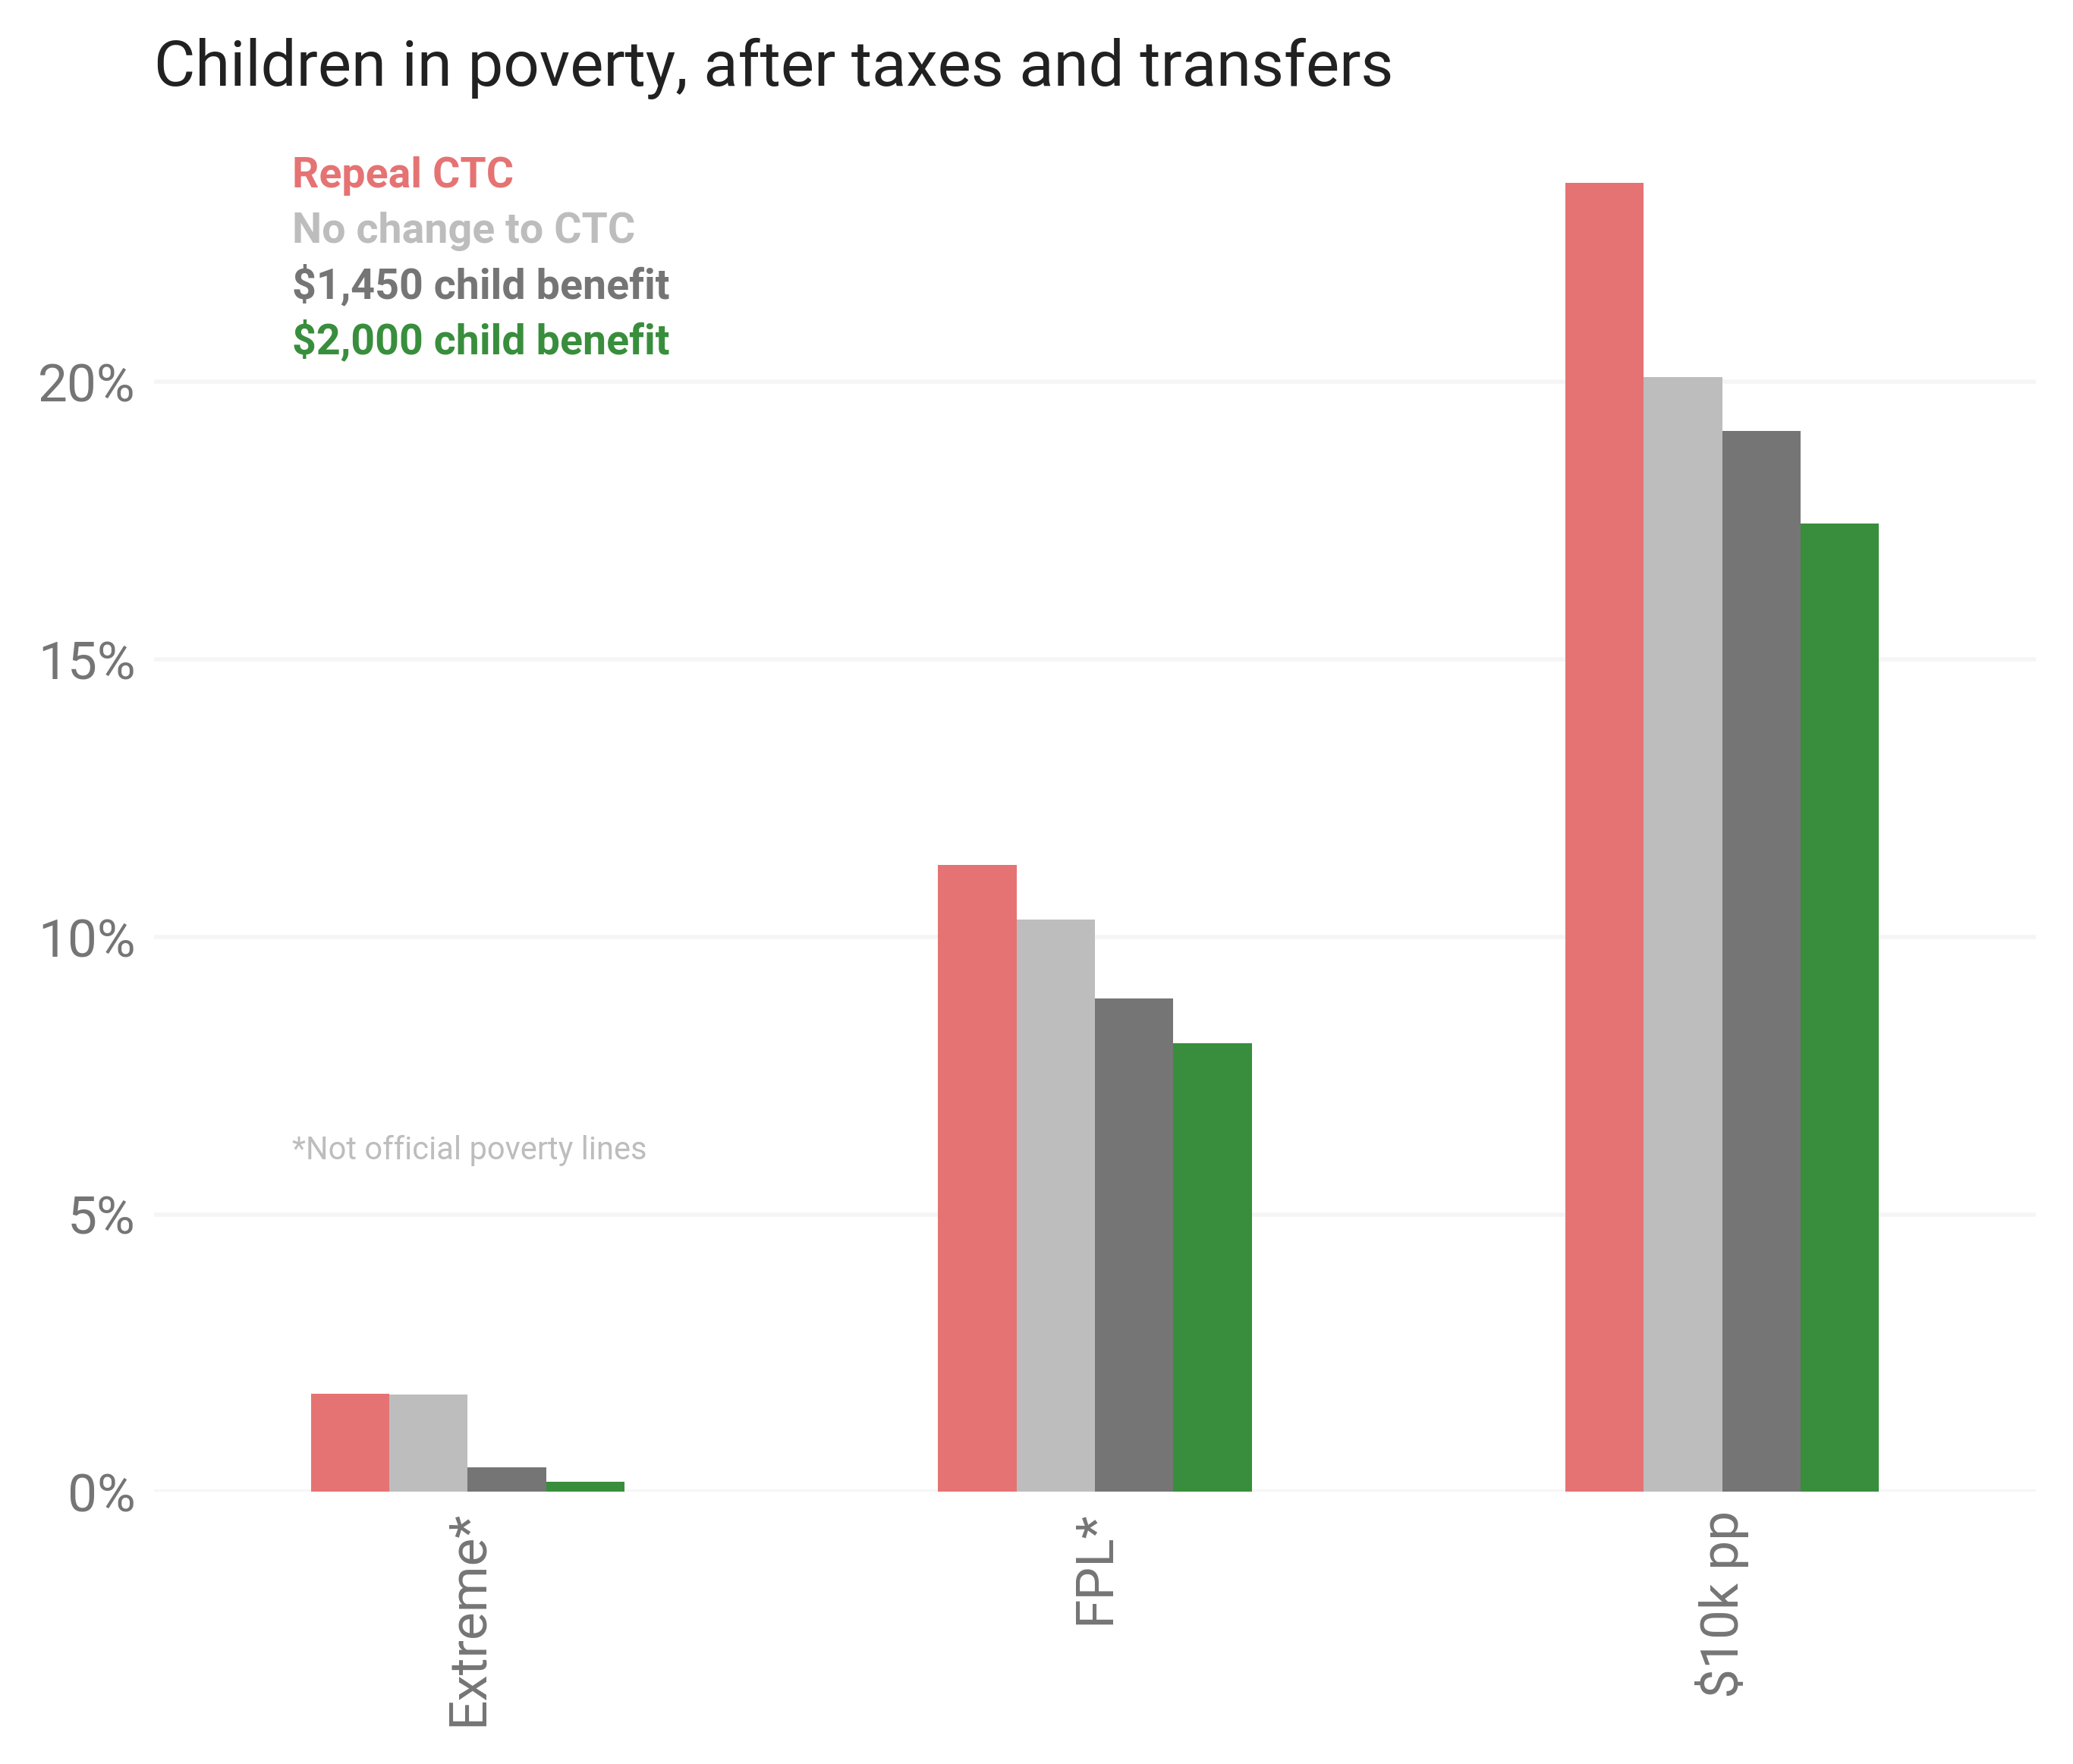

In [52]:
REPEAL_COLOR = '#e57373'  # Red from material.io/color.
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
ax = pov_wide_n24.plot.bar(
    color=[REPEAL_COLOR, KEEP_COLOR, UBI_COLOR, TUBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
ax.legend_.remove()
LEFT_X = -0.28
ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
        color=REPEAL_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
        color=KEEP_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
        horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
        horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

Relative reductions.

In [53]:
pov_wide_n24['ubi_reduction'] = 1 - (
    pov_wide_n24.afti_ubi / pov_wide_n24.afti_keep)
pov_wide_n24['tubi_reduction'] = 1 - (
    pov_wide_n24.afti_tubi / pov_wide_n24.afti_keep)
pov_wide_n24 * 100

,afti_repeal,afti_keep,afti_ubi,afti_tubi,ubi_reduction,tubi_reduction
pov_line,,,,,,
extreme_pov,1.76,1.75,0.44,0.19,75.03,89.42
fpl,11.30,10.31,8.89,8.08,13.85,21.64
pov_10k,23.58,20.07,19.11,17.44,4.82,13.12


## Appendix

### Tax units in poverty

In [54]:
# Widen and reorder for plotting.
pov_wide = pov.pivot_table(index=['pov_line', 'metric'], columns='afti')
pov_wide.columns = ['afti_keep', 'afti_repeal', 'afti_tubi', 'afti_ubi']
pov_wide = pov_wide[['afti_repeal', 'afti_keep', 'afti_ubi', 'afti_tubi']]

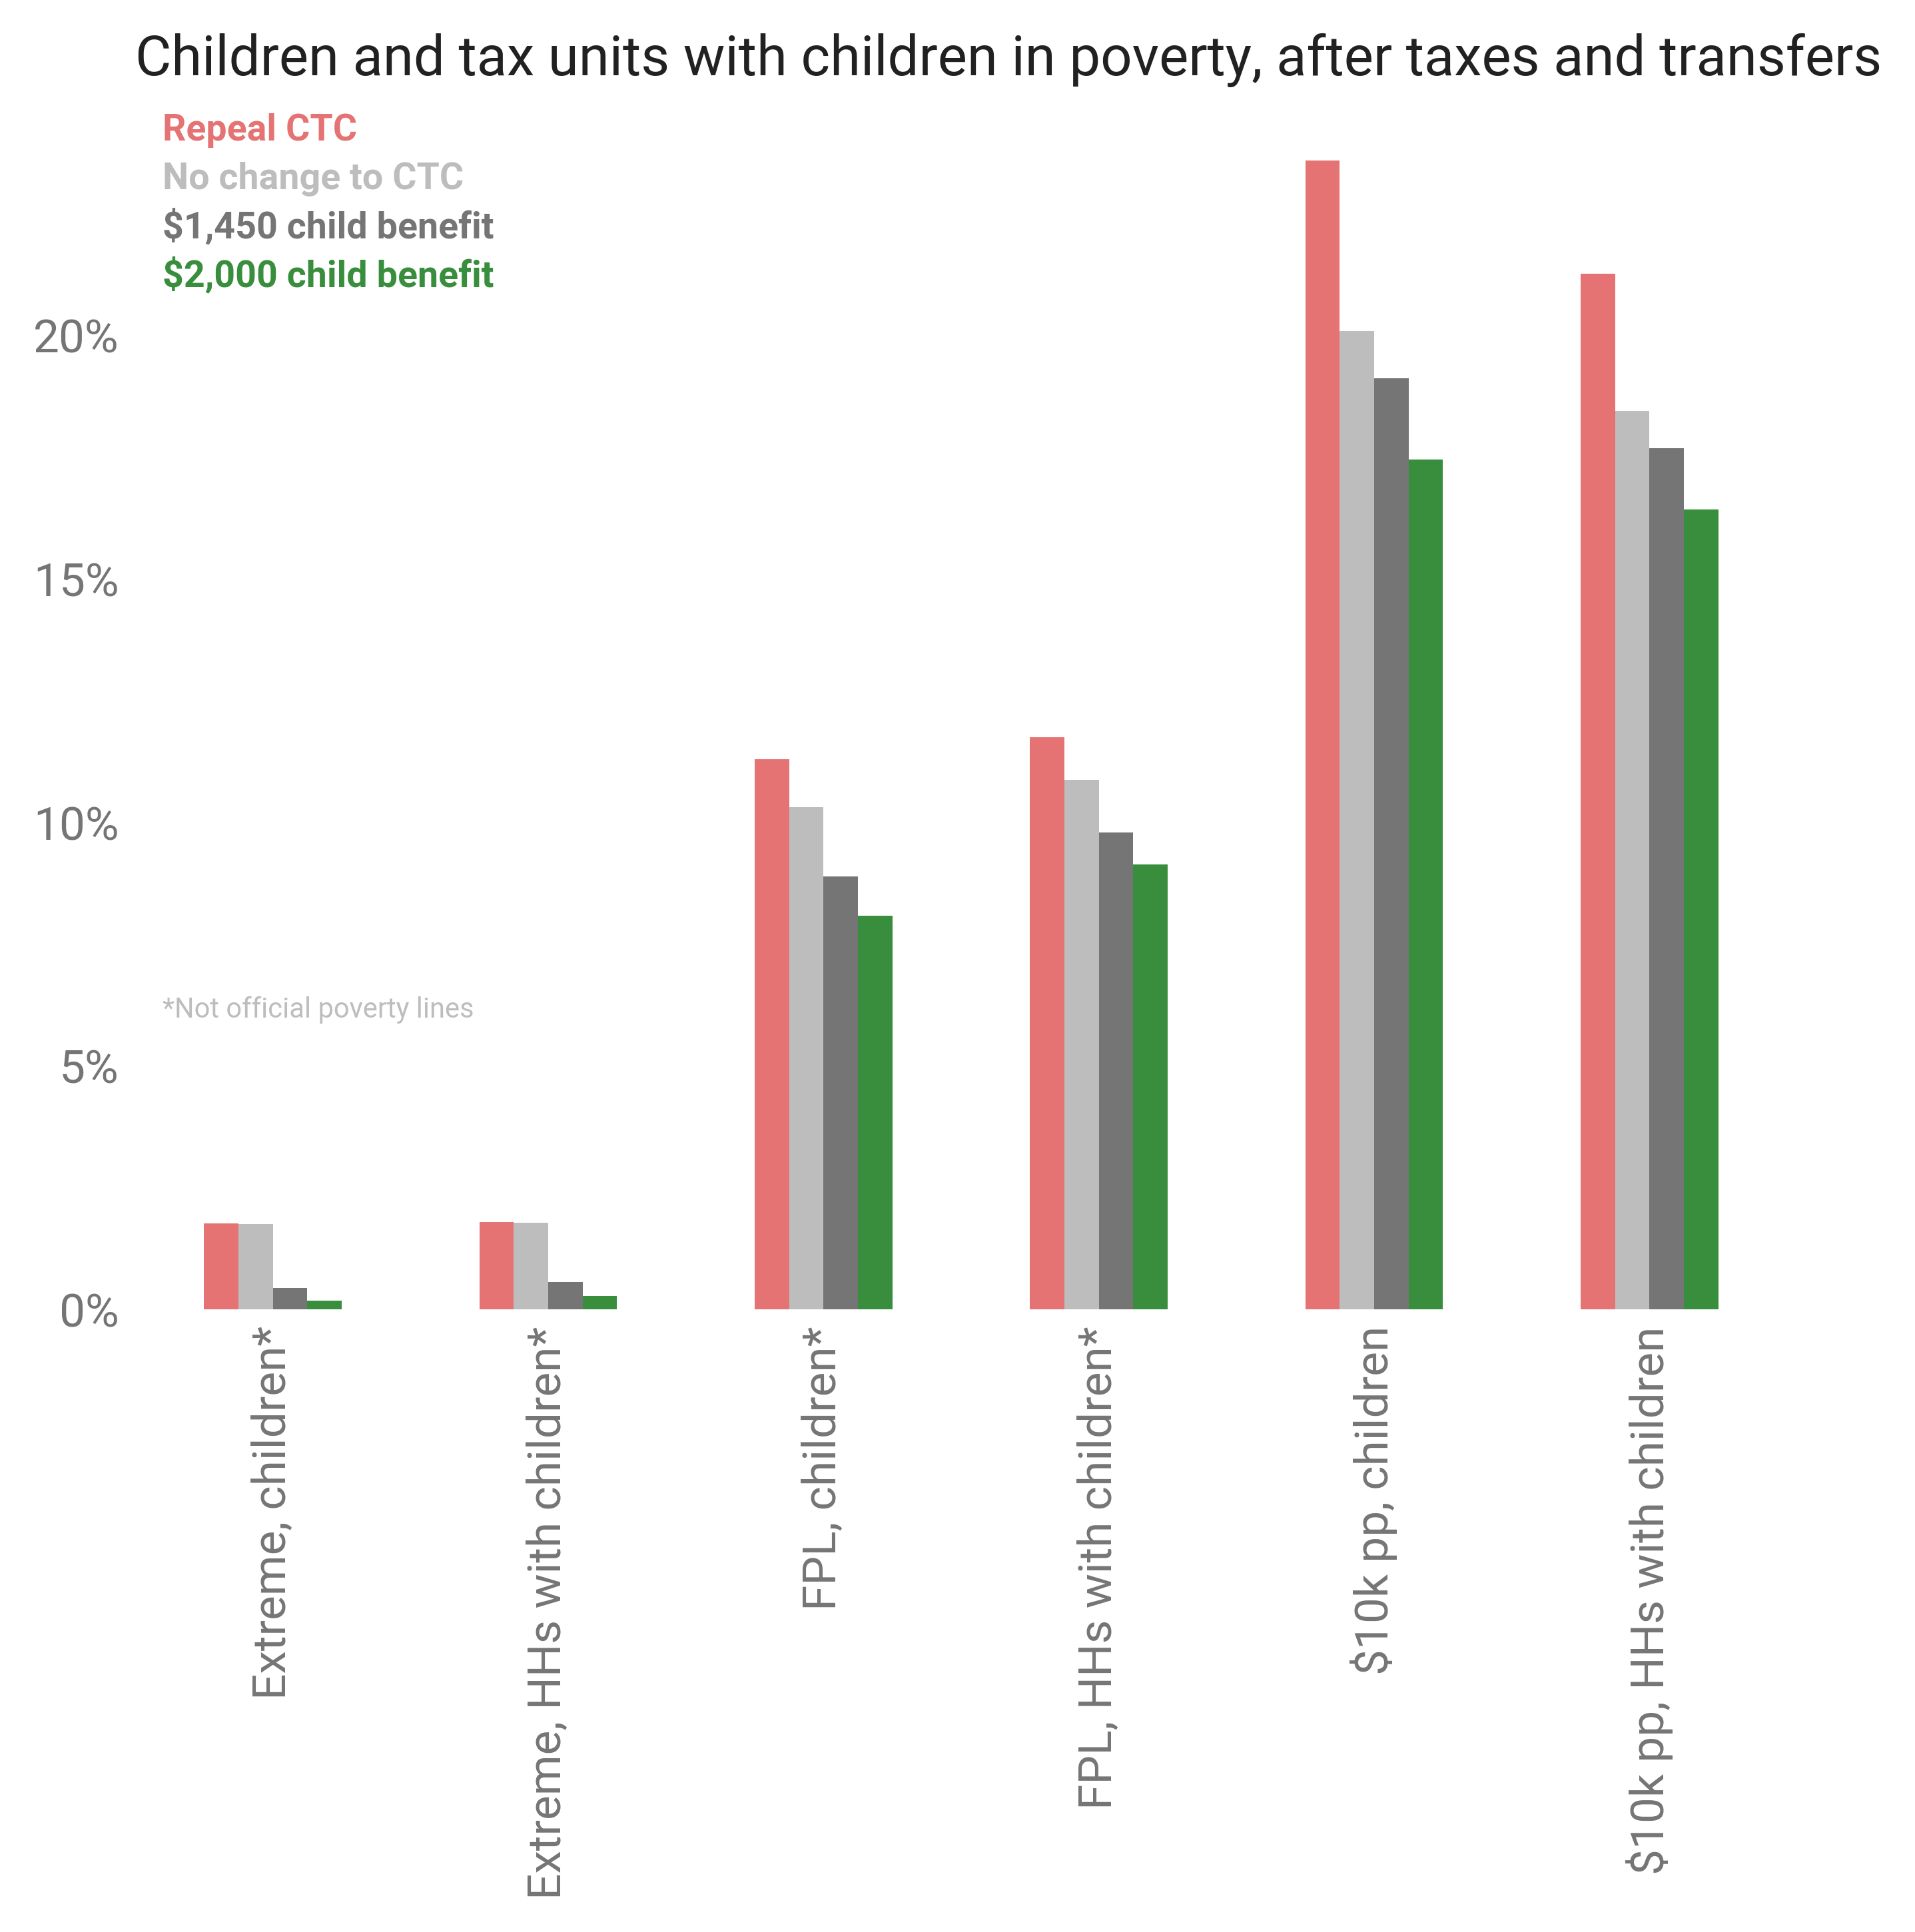

In [55]:
REPEAL_COLOR = '#e57373'  # Red from material.io/color.
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
ax = pov_wide.plot.bar(color=[REPEAL_COLOR, KEEP_COLOR, UBI_COLOR, 
                              TUBI_COLOR])
ax.set_xticklabels(('Extreme, children*', 'Extreme, HHs with children*',
                    'FPL, children*', 'FPL, HHs with children*', 
                    '$10k pp, children', '$10k pp, HHs with children'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
ax.legend_.remove()
LEFT_X = -0.4
ax.text(LEFT_X, 0.24, 'Repeal CTC', horizontalalignment='left',
        color=REPEAL_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.23, 'No change to CTC', horizontalalignment='left',
        color=KEEP_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.22, rn_ubi_str + ' child benefit', 
        horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.21, '$2,000 child benefit', 
        horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children and tax units with children in poverty, ' +
          'after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
plt.show()